In [3]:
import iris

CUBES = None
def load_cubes(address):
    def fix_metadata(cube, field, filename):
        if not cube.coords('realization'):
            realization = int(filename.split('_')[-2])
            realization_coord = iris.coords.AuxCoord(
                realization, standard_name='realization', var_name='realization')
            cube.add_aux_coord(realization_coord)
        cube.coord('realization').points.dtype = 'int32'
        cube.coord('time').var_name = 'time'
        cube.coord('forecast_period').var_name = 'forecast_period'
    CUBES = 'some'
    return iris.load_cube(address, 'visibility_in_air', callback=fix_metadata)


In [23]:
from boto.s3.connection import S3Connection
import os

os.environ['S3_USE_SIGV4'] = 'True'

def list_files(bucket):
    conn = S3Connection(host='s3.eu-west-2.amazonaws.com')
    bucket = conn.get_bucket(bucket)
    keys = iter(bucket.list(prefix='prods_op_mogreps-g_20160101_00_'))
    return ['/usr/local/share/notebooks/data/mogreps-g/{}'.format(k.key) for k in keys]


in_files = list_files('mogreps-g')[:10]
print(len(in_files))
in_files[:10]

10


['/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_003.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_006.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_009.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_012.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_015.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_018.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_021.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_024.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_027.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_030.nc']

In [24]:
dsk = {}

for i, f in enumerate(in_files):
    dsk['load-{}'.format(i)] = (load_cubes, f)

dsk['cubelist-0'] = (iris.cube.CubeList, ['load-{}'.format(i) for i in range(len(in_files))])

dsk['merged'] = (iris.cube.CubeList.merge_cube, 'cubelist-0')

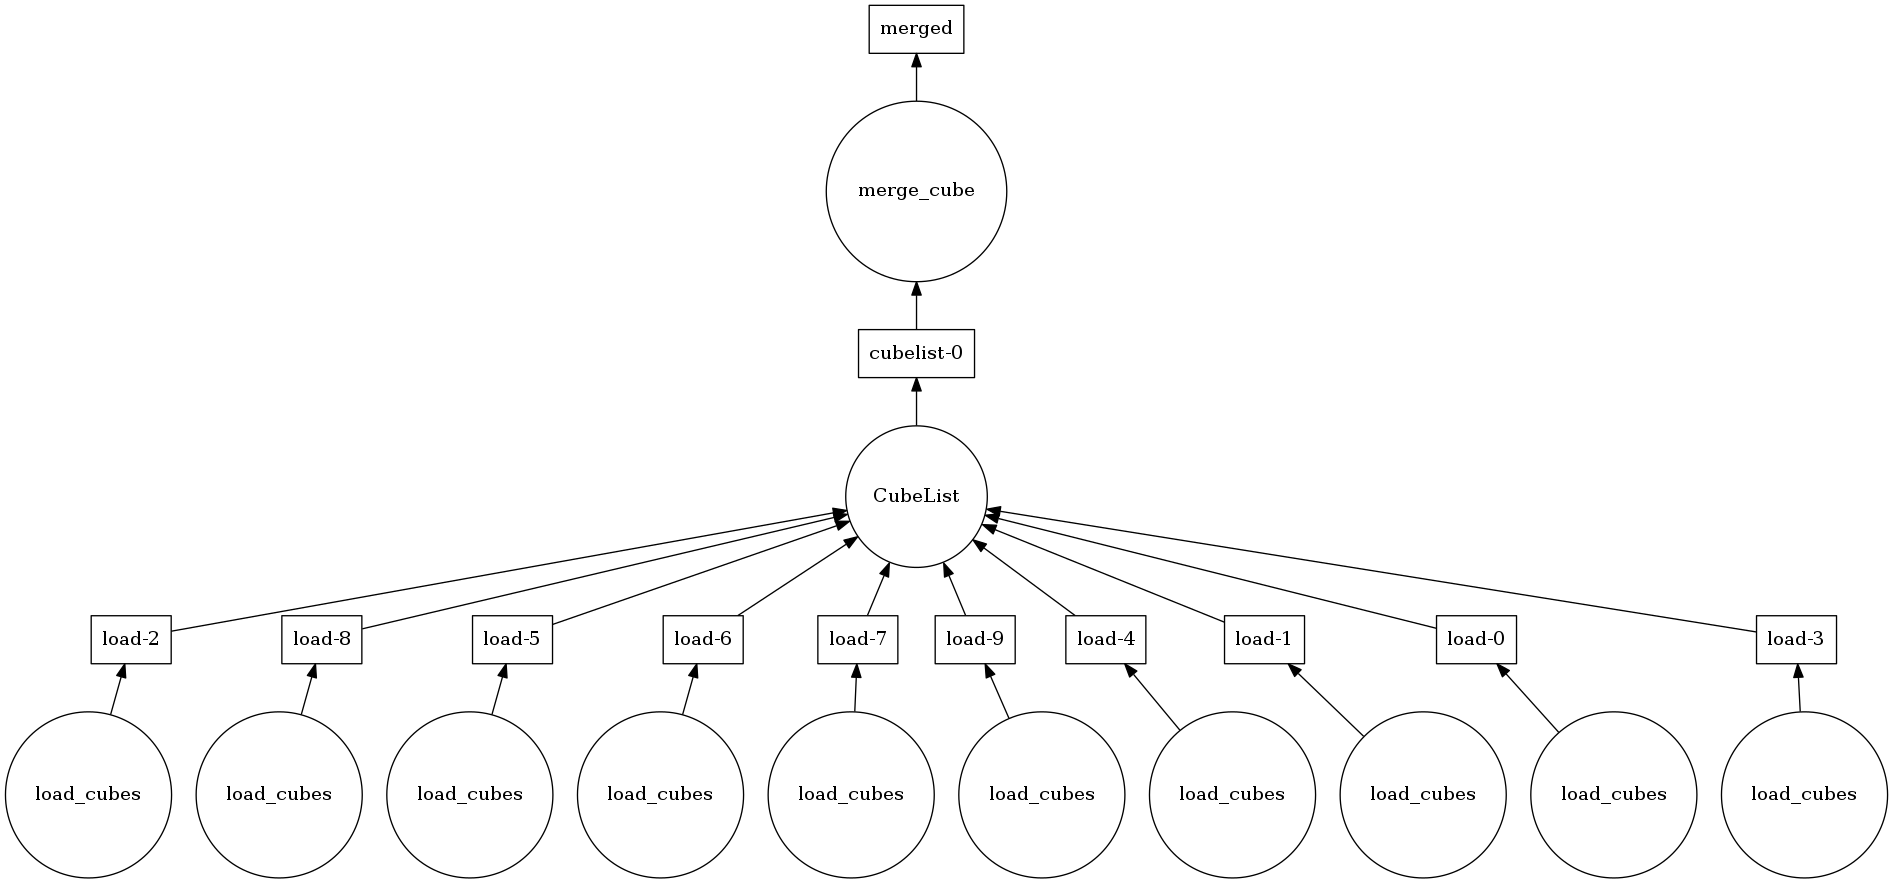

In [25]:
from dask.dot import dot_graph
dot_graph(dsk)

In [31]:
import distributed

c = distributed.Client('172.31.18.5:8786')

x = c.get(dsk, ['cubelist-0'])

distributed.utils - ERROR - cubelist-0
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/distributed/client.py", line 893, in _gather
    st = self.futures[key]
KeyError: 'cubelist-0'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/distributed/utils.py", line 149, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/opt/conda/lib/python3.5/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/opt/conda/lib/python3.5/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/opt/conda/lib/python3.5/site-packages/tornado/gen.py", line 1021, in run
    yielded = self.gen.throw(*exc_info)
  File "/opt/conda/lib/python3.5/site-packages/distributed/client.py", line 900, in _gather
    None)
  File "/opt/conda/lib/pyth

KeyboardInterrupt: 

In [33]:
for i in range(len(in_files)):
    c.get(dsk, 'load-{}'.format(i))
    print('ey')

distributed.utils - ERROR - ('load-0', '172.31.2.77:41977')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/distributed/utils.py", line 149, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/opt/conda/lib/python3.5/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/opt/conda/lib/python3.5/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/opt/conda/lib/python3.5/site-packages/tornado/gen.py", line 1021, in run
    yielded = self.gen.throw(*exc_info)
  File "/opt/conda/lib/python3.5/site-packages/distributed/client.py", line 896, in _gather
    st.traceback)
  File "/opt/conda/lib/python3.5/site-packages/six.py", line 686, in reraise
    raise value
distributed.scheduler.KilledWorker: ('load-0', '172.31.2.77:41977')


KilledWorker: ('load-0', '172.31.2.77:41977')

In [28]:
c.restart()

KeyboardInterrupt: 